In [26]:
import os
import sys
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

In [27]:
project_root = "/Users/yasemindilarasucu/Desktop/Chem277-Team4-Project"
sys.path.insert(0, project_root)

from src.model import MultiTaskGNN

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# load graph data
data_path = os.path.join(project_root, "data/02-preprocessed/processed_graph.pt")
data = torch.load(data_path)
data = data.to(device)

print("Num nodes:", data.num_nodes)
print("Num features:", data.num_node_features)

Device: cpu
Num nodes: 6386
Num features: 8


In [28]:
# recreate model with same hyperparameters as train.py

hidden_dim = 64
num_heads = 8
dropout = 0.6

model = MultiTaskGNN(
    in_channels=data.num_node_features,
    hidden_channels=hidden_dim,
    out_channels=4,
    heads=num_heads,
    dropout=dropout
).to(device)

# load best weights

best_model_path = os.path.join(project_root, "models/best_model.pt")
state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Loaded best model from:", best_model_path)


Loaded best model from: /Users/yasemindilarasucu/Desktop/Chem277-Team4-Project/models/best_model.pt


In [29]:
def eval_model_detailed(model, data, mask):
    model.eval()
    with torch.no_grad():
        pred_ad, pred_pd, pred_ftd, pred_als, _ = model(data)
        y_true = data.y

        preds = torch.cat([pred_ad, pred_pd, pred_ftd, pred_als], dim=1)

        # apply mask
        y = y_true[mask].cpu().numpy()
        yhat = preds[mask].cpu().numpy()

    metrics = {}
    diseases = ["AD", "PD", "FTD", "ALS"]

    for i, name in enumerate(diseases):
        mse = np.mean((yhat[:, i] - y[:, i]) ** 2)
        rmse = np.sqrt(mse)
        r2 = r2_score(y[:, i], yhat[:, i])

        metrics[name] = {
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
        }

    # total MSE 
    total_mse = sum(m["MSE"] for m in metrics.values())
    metrics["TOTAL"] = {"MSE": total_mse}

    return metrics


In [30]:
# evaluate on train / val / test
train_metrics = eval_model_detailed(model, data, data.train_mask)
val_metrics   = eval_model_detailed(model, data, data.val_mask)
test_metrics  = eval_model_detailed(model, data, data.test_mask)

print("TRAIN:")
for k, v in train_metrics.items():
    print(k, v)

print("\nVAL:")
for k, v in val_metrics.items():
    print(k, v)

print("\nTEST:")
for k, v in test_metrics.items():
    print(k, v)

TRAIN:
AD {'MSE': 0.0029379397, 'RMSE': 0.054202765, 'R2': 0.014561232993924644}
PD {'MSE': 0.0012869256, 'RMSE': 0.035873745, 'R2': -0.0019901053637101374}
FTD {'MSE': 0.0016098507, 'RMSE': 0.040122945, 'R2': -0.01833723069654014}
ALS {'MSE': 0.0046517258, 'RMSE': 0.06820356, 'R2': 0.006660282924122463}
TOTAL {'MSE': 0.010486441780813038}

VAL:
AD {'MSE': 0.0033223315, 'RMSE': 0.05763967, 'R2': 0.008028545733026249}
PD {'MSE': 0.0012785428, 'RMSE': 0.03575672, 'R2': -0.0008934568118761366}
FTD {'MSE': 0.0016773787, 'RMSE': 0.04095581, 'R2': -0.02296301013015767}
ALS {'MSE': 0.0049989326, 'RMSE': 0.07070313, 'R2': 0.004727843671302523}
TOTAL {'MSE': 0.011277185520157218}

TEST:
AD {'MSE': 0.0033418706, 'RMSE': 0.057808913, 'R2': 0.01907260864111171}
PD {'MSE': 0.0013906042, 'RMSE': 0.037290804, 'R2': -0.036961262617327906}
FTD {'MSE': 0.0016027134, 'RMSE': 0.040033903, 'R2': -0.030692020294504907}
ALS {'MSE': 0.004643505, 'RMSE': 0.06814327, 'R2': 0.002782745493197347}
TOTAL {'MSE': 0.

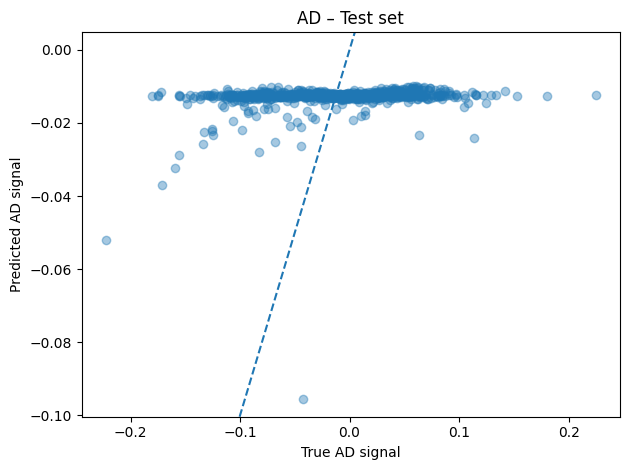

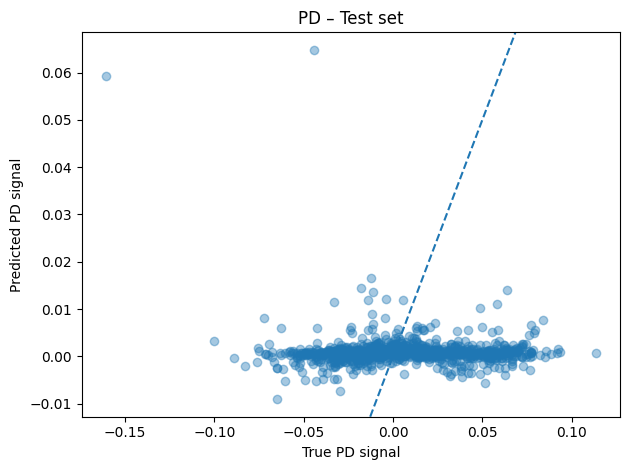

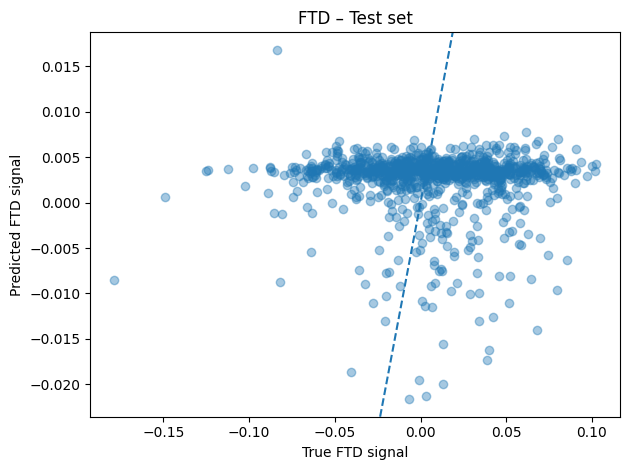

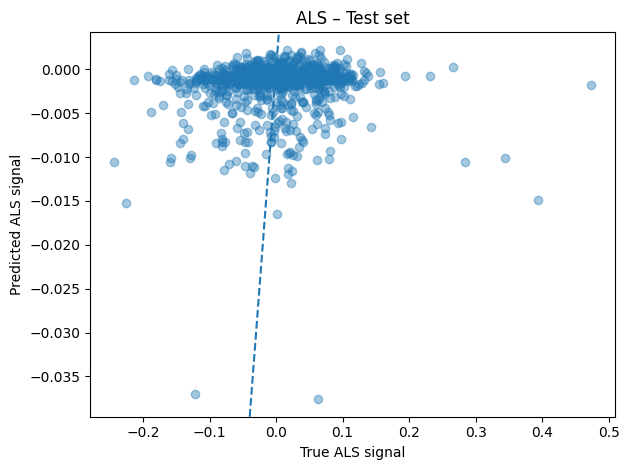

In [31]:

def plot_true_vs_pred(model, data, mask, split_name="Test"):
    model.eval()
    with torch.no_grad():
        pred_ad, pred_pd, pred_ftd, pred_als, _ = model(data)
        preds = torch.cat([pred_ad, pred_pd, pred_ftd, pred_als], dim=1)

        y_true = data.y[mask].cpu().numpy()
        y_pred = preds[mask].cpu().numpy()

    diseases = ["AD", "PD", "FTD", "ALS"]
    for i, name in enumerate(diseases):
        plt.figure()
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.4)
        plt.xlabel(f"True {name} signal")
        plt.ylabel(f"Predicted {name} signal")
        plt.title(f"{name} – {split_name} set")
        plt.axline((0, 0), slope=1, linestyle="--")
        plt.tight_layout()
        plt.show()

# plot for test set
plot_true_vs_pred(model, data, data.test_mask, split_name="Test")


In [32]:
# 1. get embeddings from the best model
model.eval()
with torch.no_grad():
    _, _, _, _, embeddings = model(data)

emb_np = embeddings.cpu().numpy()
print("Embedding shape:", emb_np.shape)  # (6386, 64)

# 2. UMAP to 2D
umap_model = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    random_state=42,
)
emb_2d = umap_model.fit_transform(emb_np)

# 3. HDBSCAN clustering
sizes_to_try = [15, 25, 35, 50, 75, 100]
best_score = -1
best_labels = None
best_size = None

for size in sizes_to_try:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    labels = clusterer.fit_predict(emb_2d)
    n_clusters = len(np.unique(labels[labels != -1]))

    if n_clusters >= 2:
        mask = labels != -1
        score = silhouette_score(emb_2d[mask], labels[mask])
        print(f"size={size:3d}: {n_clusters:2d} clusters, silhouette={score:.4f}")
        if score > best_score:
            best_score = score
            best_labels = labels
            best_size = size
    else:
        print(f"size={size:3d}: only {n_clusters} clusters, skipping")

print("\nBest clustering: min_size =", best_size, ", silhouette =", best_score)

# 4. Build dataframe linking embeddings + clusters + betas
df = pd.DataFrame(emb_2d, columns=["UMAP1", "UMAP2"])
df["GeneSymbol"] = data.gene_symbols
df["ClusterLabel"] = best_labels
df["Cluster"] = df["ClusterLabel"].apply(lambda x: f"Cluster {x}" if x != -1 else "Noise")

print(df.head())


Embedding shape: (6386, 64)


/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


size= 15: 22 clusters, silhouette=0.3369
size= 25: 11 clusters, silhouette=0.3431
size= 35:  8 clusters, silhouette=0.3358
size= 50:  4 clusters, silhouette=0.3892
size= 75:  3 clusters, silhouette=0.4817
size=100:  2 clusters, silhouette=0.5017

Best clustering: min_size = 100 , silhouette = 0.501675
      UMAP1     UMAP2 GeneSymbol  ClusterLabel    Cluster
0  0.031242  8.424040     CRYBB2             1  Cluster 1
1 -5.516991  7.332427       RAF1             1  Cluster 1
2 -6.770011  6.346362      ZNF41             1  Cluster 1
3 -1.191490  4.006000       ELK1            -1      Noise
4 -5.220541  5.817194     GUCA1A             1  Cluster 1


In [33]:
# join with original features

features = pd.read_csv(os.path.join(project_root, "data/02-preprocessed/protein_features.csv"),
                       index_col="GeneSymbol")

merged = features.join(df.set_index("GeneSymbol")["Cluster"])
beta_cols = ["AD_beta", "PD_beta", "FTD_beta", "ALS_beta"]

cluster_avg = merged.groupby("Cluster")[beta_cols].mean()
if "Noise" in cluster_avg.index:
    cluster_avg = cluster_avg.drop("Noise")

cluster_avg


,AD_beta,PD_beta,FTD_beta,ALS_beta
Cluster,,,,
Cluster 0,-0.000947,0.001341,0.003760,-0.001166
Cluster 1,-0.011825,0.003579,0.006263,0.000956


In [34]:
print("X shape:", data.x.shape)
print("Y shape:", data.y.shape)

print("\nFeature stats (first 5 dims):")
x = data.x
print("  mean:", x.mean(dim=0)[:5].cpu().numpy())
print("  std :", x.std(dim=0)[:5].cpu().numpy())

print("\nTarget stats:")
y = data.y
print("  mean:", y.mean(dim=0).cpu().numpy())
print("  std :", y.std(dim=0).cpu().numpy())
print("  min :", y.min(dim=0).values.cpu().numpy())
print("  max :", y.max(dim=0).values.cpu().numpy())

X shape: torch.Size([6386, 8])
Y shape: torch.Size([6386, 4])

Feature stats (first 5 dims):
  mean: [-1.2980904e-02  5.6216612e+00  4.4018677e-03  5.5166430e+00
  6.5574907e-03]
  std : [0.05569128 7.388903   0.03594911 7.283739   0.03982885]

Target stats:
  mean: [-0.0129809   0.00440187  0.00655749  0.00050544]
  std : [0.05569128 0.03594911 0.03982885 0.06879342]
  min : [-0.22227047 -0.1648529  -0.23008586 -0.4974214 ]
  max : [0.28841078 0.25318515 0.1449121  0.5110176 ]
